We plot the gap distance for a fixed input norma for a range of value of delta.

In [2]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import perturbed_organics.utils as utils
import math


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cmap = 'plasma_r'

In [3]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)

folder_loc = f'/scratch/sr6364/perturbed_organics/data/adaptive_phase_diagram_100/{input_type}'
# folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_200_num_input_200_num_trials_100_b0_1.0_b1_1.0_phase_diagram_linear'
folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_200_num_input_200_num_trials_100_b0_1.0_b1_1.0_phase_diagram_log-scale'


path = os.path.join(folder_loc, folder_name)

In [4]:
# Load parameters from the JSON file
param_file_path = os.path.join(path, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
delta_scale = params['delta_scale']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [5]:
# analytical prediction from perturbation theory
num_points_to_exclude = 3
idx = 0
norm_sol_idx = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=params['model_name'], input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (params['sigma']**2 + torch.norm(z) ** 2))
    norm_sol_idx.append(norm_eqn[idx].item())
norm_sol_idx = np.array(norm_sol_idx)

# analytical solution for the mean of the fixed point
G = (1 - np.sqrt(params['sigma'] ** 2 + input_range ** 2)) / (params['sigma'] ** 2 + input_range ** 2)
analytical_mean = norm_sol_idx + mu_val * input_range * G * (1 - input_range ** 2 / (params['sigma'] ** 2 + input_range ** 2)) / np.sqrt(N)


delta_c =  math.sqrt(2 * N) * analytical_mean / (G * input_range)
delta_c = delta_c[:-num_points_to_exclude]
new_input_norm = input_range[:-num_points_to_exclude]

In [6]:
folder_loc = f'../figures/mu_{mu}/fig_histogram'
os.makedirs(folder_loc, exist_ok=True)

In [7]:
eigvals = torch.load(os.path.join(path, f'eigvals_J.pt')) 

/tmp/ipykernel_2894980/3821349.py:10: RuntimeWarning: All-NaN slice encountered
  max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)


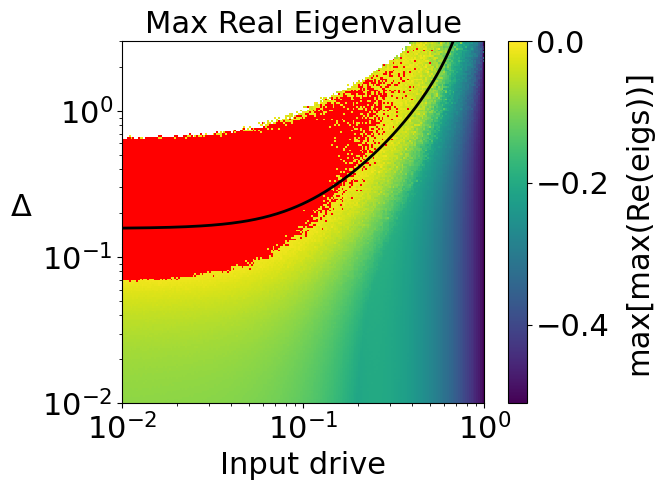

In [8]:
# define the threshold to be considered a non-gapped phase
critical_gap_threshold = 1e-2

# Compute the maximum real part for each trial (max over eigenvalue index)
max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002  # shape: (num_delta, num_input, num_trials)

# find the max of the trials; ignore the trials with positive values
max_real_each_trial[max_real_each_trial > 0] = np.nan

max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)

# find the values that are less than the threshold
bool_critically_slowed = np.abs(max_real_max) < critical_gap_threshold

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_real_max)
vmax = np.nanmax(max_real_max)

# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_max, cmap='viridis', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('max[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Max Real Eigenvalue", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

# Overlay red for cells where bool_critically_slowed is True
# Create a masked array: only True cells will be unmasked
import numpy.ma as ma
red_mask = ma.masked_where(~bool_critically_slowed, bool_critically_slowed)
plt.pcolormesh(input_range, delta_range, red_mask, cmap=mcolors.ListedColormap(['red']), shading='auto')

file_name = f'max_eigvals_{input_type}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


### For a given value of input norm, find the the gap distance as a function of delta and plot it.

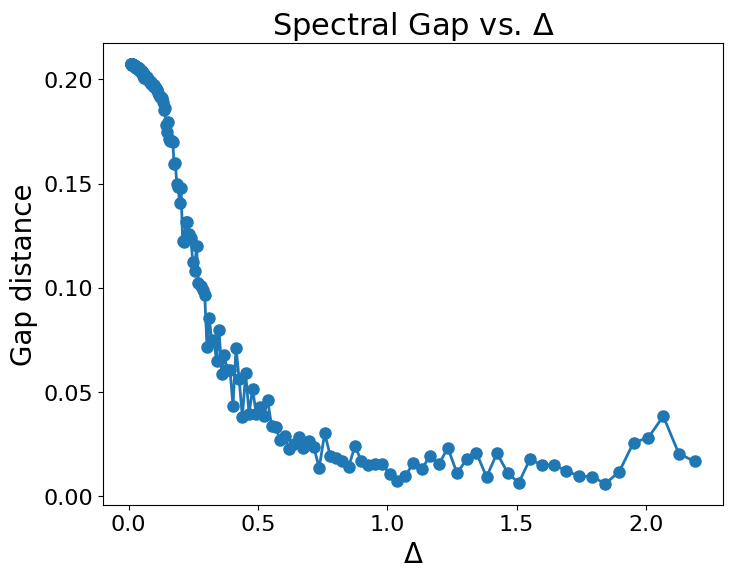

In [9]:
fixed_input_norm = 0.3  # adjust this value as needed
input_idx = np.abs(input_range - fixed_input_norm).argmin()

gap_distance = np.abs(max_real_max[:, input_idx])

plt.figure(figsize=(8,6))
plt.plot(delta_range, gap_distance, marker='o', markersize=8, linewidth=2)

plt.xlabel(r'$\Delta$', fontsize=20)
plt.ylabel('Gap distance', fontsize=20)
plt.title('Spectral Gap vs. $\Delta$', fontsize=22)

# Customize tick parameters for both axes
ax = plt.gca()

# Set maximum number of ticks on the x-axis and y-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Set tick font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

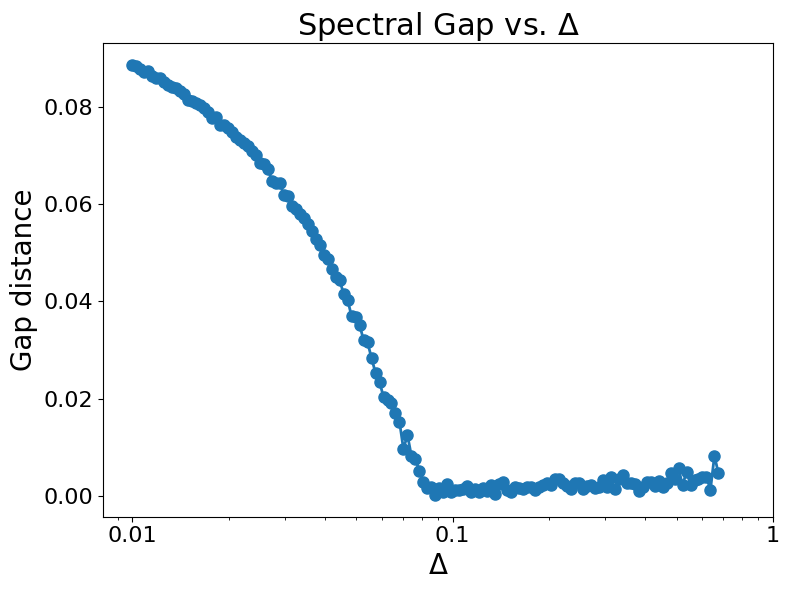

In [10]:
fixed_input_norm = 0.02  # adjust this value as needed
input_idx = np.abs(input_range - fixed_input_norm).argmin()

gap_distance = np.abs(max_real_max[:, input_idx])

plt.figure(figsize=(8,6))
plt.plot(delta_range, gap_distance, marker='o', markersize=8, linewidth=2)

plt.xlabel(r'$\Delta$', fontsize=20)
plt.ylabel('Gap distance', fontsize=20)
plt.title('Spectral Gap vs. $\Delta$', fontsize=22)

# plot x axis in  logscale
plt.xscale('log')

# Customize tick parameters for both axes
ax = plt.gca()

# Set maximum number of ticks on the x-axis and y-axis
tick_values = [0.01, 0.1, 1]
ax.set_xticks(tick_values)
ax.set_xticklabels([str(t) for t in tick_values])

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Set tick font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add grid lines for readability
# plt.grid(True, linestyle='--', alpha=0.7)

folder_loc = f'../figures/mu_{mu}/fig_histogram'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'gap_distance_phase_diagram'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()

Setting y-axis (Critical Delta) to log scale.


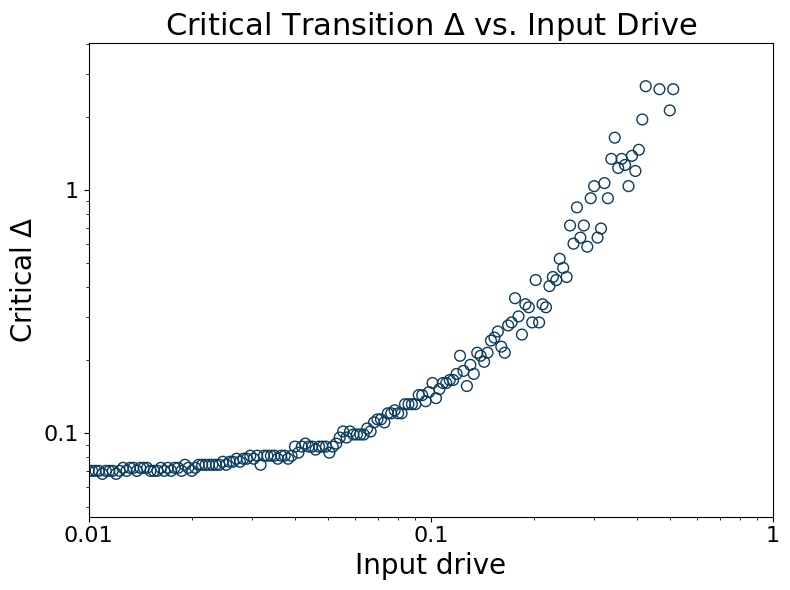

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

critical_gap_threshold = 1e-2

critical_deltas = np.full_like(input_range, np.nan)

for i, input_val in enumerate(input_range):
    gap_distances_for_input = np.abs(max_real_max[:, i])
    below_threshold_indices = np.where(gap_distances_for_input < critical_gap_threshold)[0]
    if len(below_threshold_indices) > 0:
        first_transition_index = below_threshold_indices[0]
        critical_deltas[i] = delta_range[first_transition_index]

plt.figure(figsize=(8, 6))

# Plot only the points where a critical delta was found (not NaN)
valid_indices = ~np.isnan(critical_deltas)
plt.scatter(input_range[valid_indices], critical_deltas[valid_indices],
            s=60, facecolors='none', edgecolors='#0b3c5d', label='Critical $\Delta$')

plt.xlabel('Input drive', fontsize=20)
plt.ylabel('Critical $\Delta$', fontsize=20)
plt.title('Critical Transition $\Delta$ vs. Input Drive', fontsize=22)

plt.xscale('log')

# Customize tick parameters for both axes
ax = plt.gca()

# Format both axes to use regular float notation
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())


# Optionally, set the y-axis to log scale if needed
if delta_scale == 'log-scale':
    plt.yscale('log')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    print("Setting y-axis (Critical Delta) to log scale.")
    

# Set tick font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set axis limits with padding
if np.any(valid_indices):
    plt.xlim([input_range[0], input_range[-1]])
    min_crit_delta = np.nanmin(critical_deltas)
    max_crit_delta = np.nanmax(critical_deltas)
    if delta_scale == 'log-scale':
        plt.ylim([min_crit_delta / 1.5, max_crit_delta * 1.5])
    else:
        padding = (max_crit_delta - min_crit_delta) * 0.1
        plt.ylim([min_crit_delta - padding, max_crit_delta + padding])
else:
    print("Warning: No critical delta transitions found below the threshold.")

# Save the figure
folder_loc_crit = f'../figures/mu_{mu}/fig_histogram'
os.makedirs(folder_loc_crit, exist_ok=True)
file_name_crit = 'critical_delta_vs_input'
file_save_path_crit = os.path.join(folder_loc_crit, file_name_crit)

plt.tight_layout()
plt.savefig(f'{file_save_path_crit}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path_crit}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path_crit}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


/tmp/ipykernel_2894980/1380060424.py:10: RuntimeWarning: All-NaN slice encountered
  max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)


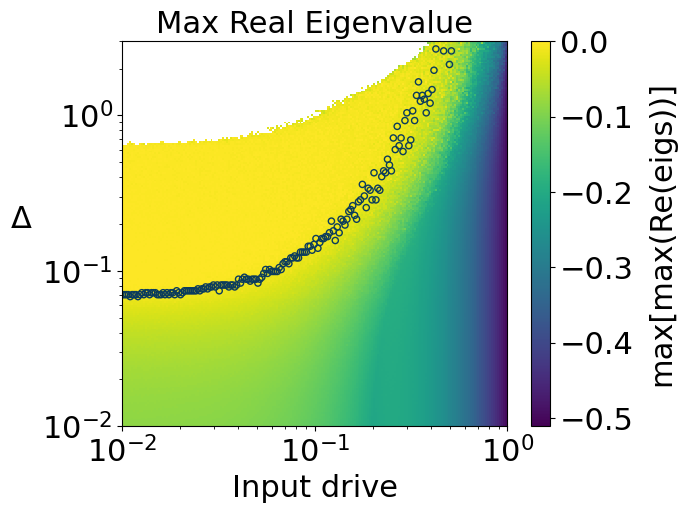

: 

In [ ]:
# define the threshold to be considered a non-gapped phase
critical_gap_threshold = 1e-2

# Compute the maximum real part for each trial (max over eigenvalue index)
max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002  # shape: (num_delta, num_input, num_trials)

# find the max of the trials; ignore the trials with positive values
max_real_each_trial[max_real_each_trial > 0] = np.nan

max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)

# find the values that are less than the threshold
bool_critically_slowed = np.abs(max_real_max) < critical_gap_threshold

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_real_max)
vmax = np.nanmax(max_real_max)

# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_max, cmap='viridis', norm=norm)
# plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

plt.scatter(input_range[valid_indices], critical_deltas[valid_indices],
            s=20, facecolors='none', edgecolors='#0b3c5d', label='Critical $\Delta$')


colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('max[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Max Real Eigenvalue", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])


plt.show()


### Find the values of delta at which normalization breaks down.

In [13]:
condition = torch.load(os.path.join(path, f'condition.pt'))
norm_fixed_point_y = torch.load(os.path.join(path, f'norm_fixed_point_y.pt'))
actual_fixed_point_y = torch.load(os.path.join(path, f'actual_fixed_point_y.pt'))
first_order_perturb_y = torch.load(os.path.join(path, f'first_order_perturb_y.pt'))

In [14]:
# fit and find the intersection of mean and variance
stability_criterion_percent = 0.99
fitted_intersection = np.zeros((len(delta_range)))
idx = 0

for i, delta_val in enumerate(delta_range):
    actual_fp_y = actual_fixed_point_y[i, :, :, :]
    y_val = actual_fp_y[:, :, idx]

    y_val_mean = torch.nanmean(y_val, dim=1)
    y_val_std = utils.nanstd(y_val, dim=1)

    # check if unstable
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=1) / num_trials
    mask = (ratio_stable > stability_criterion_percent).cpu().numpy()

    # fit the mean
    x_vals = np.array(input_range)[mask].astype(np.float64)
    y_vals = np.array(y_val_mean[mask]).astype(np.float64)
    coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
    poly_func = np.poly1d(coeffs)
    x_fit_mean = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 200)
    y_fit_mean = poly_func(np.log10(x_fit_mean))

    # fit the std
    x_vals = np.array(input_range)[mask].astype(np.float64)
    y_vals = np.array(y_val_std[mask]).astype(np.float64)
    coeffs = np.polyfit(np.log10(x_vals), y_vals, deg=5)
    poly_func = np.poly1d(coeffs)
    x_fit_std = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 200)
    y_fit_std = poly_func(np.log10(x_fit_std))

    # find the intersection
    diff = y_fit_mean - y_fit_std

    # Find indices where the difference changes sign.
    sign_change_idxs = np.where(np.diff(np.sign(diff)))[0]

    if sign_change_idxs.size > 0:
        # Take the first crossing.
        idx1 = sign_change_idxs[0]
        # Define the two x values and the corresponding differences.
        x0, x1 = x_fit_mean[idx1], x_fit_mean[idx1 + 1]
        d0, d1 = diff[idx1], diff[idx1 + 1]
        
        # Linear interpolation to estimate the intersection.
        t = -d0 / (d1 - d0)
        x_intersect = x0 + t * (x1 - x0)
        
        fitted_intersection[i] = x_intersect
    else:
        fitted_intersection[i] = np.nan

Setting y-axis (Critical Delta) to log scale.


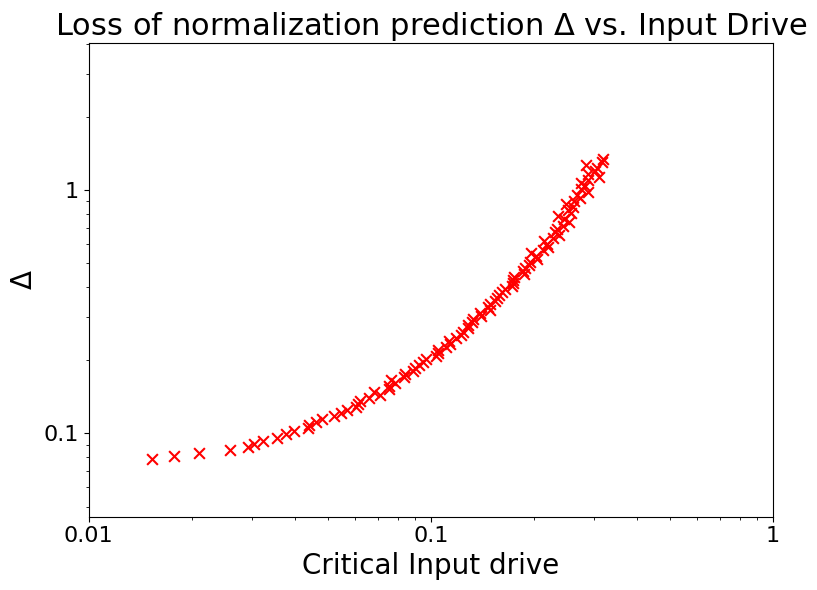

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

plt.figure(figsize=(8, 6))

plt.scatter(fitted_intersection, delta_range, color='r', s=60, marker='x')

plt.xlabel('Critical Input drive', fontsize=20)
plt.ylabel('$\Delta$', fontsize=20)
plt.title('Loss of normalization prediction $\Delta$ vs. Input Drive', fontsize=22)

plt.xscale('log')

# Customize tick parameters for both axes
ax = plt.gca()

# Format both axes to use regular float notation
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())


# Optionally, set the y-axis to log scale if needed
if delta_scale == 'log-scale':
    plt.yscale('log')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    print("Setting y-axis (Critical Delta) to log scale.")
    

# Set tick font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set axis limits with padding
if np.any(valid_indices):
    plt.xlim([input_range[0], input_range[-1]])
    min_crit_delta = np.nanmin(critical_deltas)
    max_crit_delta = np.nanmax(critical_deltas)
    if delta_scale == 'log-scale':
        plt.ylim([min_crit_delta / 1.5, max_crit_delta * 1.5])
    else:
        padding = (max_crit_delta - min_crit_delta) * 0.1
        plt.ylim([min_crit_delta - padding, max_crit_delta + padding])
else:
    print("Warning: No critical delta transitions found below the threshold.")

# Save the figure
folder_loc_crit = f'../figures/mu_{mu}/fig_loss_of_normalization'
os.makedirs(folder_loc_crit, exist_ok=True)
file_name_crit = 'delta_vs_critical_input'
file_save_path_crit = os.path.join(folder_loc_crit, file_name_crit)

plt.tight_layout()
plt.savefig(f'{file_save_path_crit}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path_crit}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path_crit}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


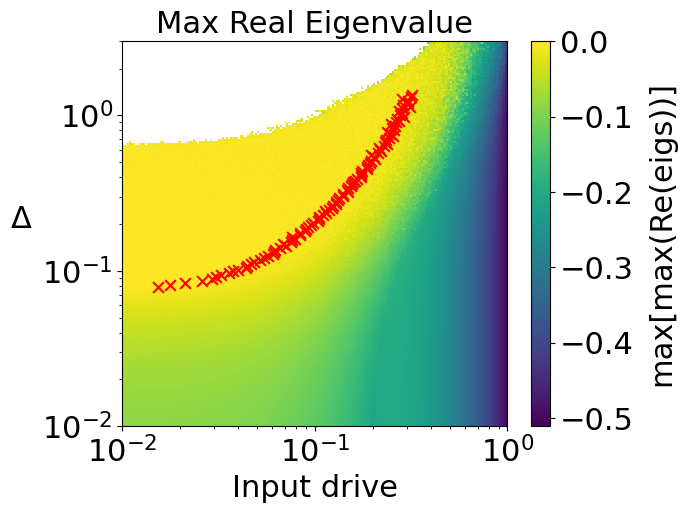

In [32]:
# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_max, cmap='viridis', norm=norm)


plt.scatter(fitted_intersection, delta_range, color='r', s=60, marker='x')


colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('max[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Max Real Eigenvalue", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])


plt.show()


### Plotting all curves on the same plot.

Setting y-axis (Critical Delta) to log scale.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


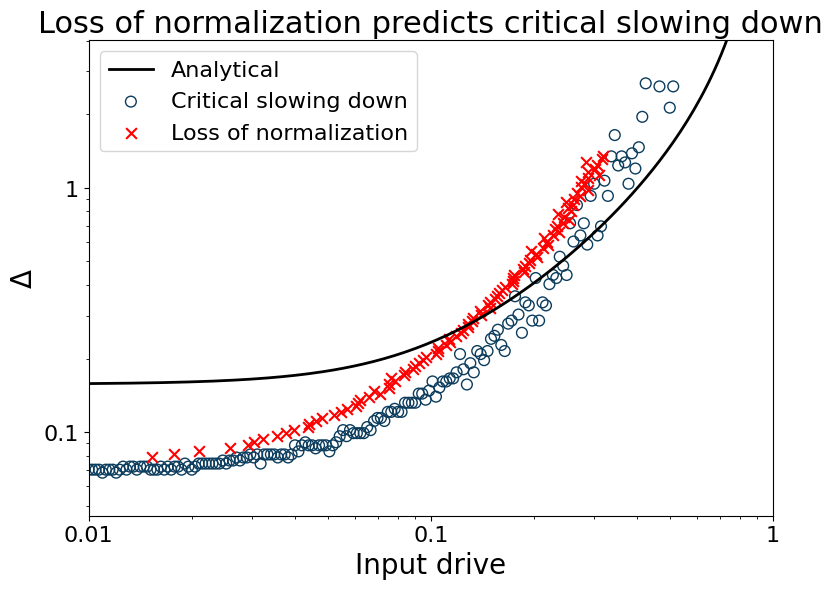

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

plt.figure(figsize=(8, 6))

# plot the analytical prediction
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'Analytical')

# Plot only the points where a critical delta was found (not NaN)
valid_indices = ~np.isnan(critical_deltas)
plt.scatter(input_range[valid_indices], critical_deltas[valid_indices],
            s=60, facecolors='none', edgecolors='#0b3c5d', label='Critical slowing down')

plt.scatter(fitted_intersection, delta_range, color='r', s=60, marker='x', label='Loss of normalization')

plt.xlabel('Input drive', fontsize=20)
plt.ylabel('$\Delta$', fontsize=20)
plt.title('Loss of normalization predicts critical slowing down', fontsize=22)

# plot legend
plt.legend(fontsize=16, loc='upper left')

plt.xscale('log')

# Customize tick parameters for both axes
ax = plt.gca()

# Format both axes to use regular float notation
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())


# Optionally, set the y-axis to log scale if needed
if delta_scale == 'log-scale':
    plt.yscale('log')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    print("Setting y-axis (Critical Delta) to log scale.")
    

# Set tick font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set axis limits with padding
if np.any(valid_indices):
    plt.xlim([input_range[0], input_range[-1]])
    min_crit_delta = np.nanmin(critical_deltas)
    max_crit_delta = np.nanmax(critical_deltas)
    if delta_scale == 'log-scale':
        plt.ylim([min_crit_delta / 1.5, max_crit_delta * 1.5])
    else:
        padding = (max_crit_delta - min_crit_delta) * 0.1
        plt.ylim([min_crit_delta - padding, max_crit_delta + padding])
else:
    print("Warning: No critical delta transitions found below the threshold.")

# Save the figure
folder_loc_crit = f'../figures/mu_{mu}/fig_loss_of_normalization'
os.makedirs(folder_loc_crit, exist_ok=True)
file_name_crit = 'lines_together'
file_save_path_crit = os.path.join(folder_loc_crit, file_name_crit)

plt.tight_layout()
plt.savefig(f'{file_save_path_crit}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path_crit}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path_crit}.eps', format='eps', bbox_inches='tight', dpi=300)

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


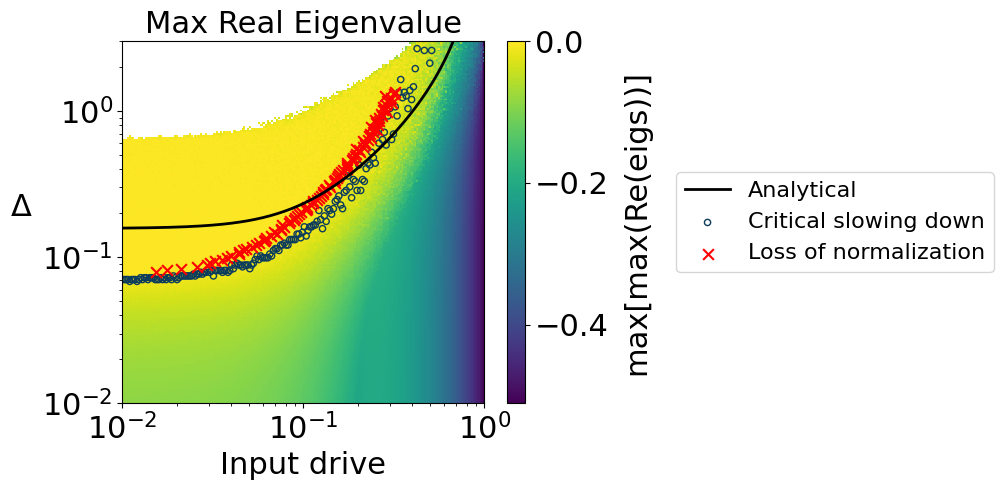

In [31]:
# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(10.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_max, cmap='viridis', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'Analytical')

plt.scatter(input_range[valid_indices], critical_deltas[valid_indices],
            s=20, facecolors='none', edgecolors='#0b3c5d', label='Critical slowing down')

plt.scatter(fitted_intersection, delta_range, color='r', s=60, marker='x', label='Loss of normalization')


colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('max[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Max Real Eigenvalue", fontsize=22)

ax = plt.gca()
if delta_scale == 'log-scale':
    plt.yscale('log')  # Ensure the axis is in log scale
    y_span = np.log10(delta_range[-1]) - np.log10(delta_range[0])
else:  
    y_span = delta_range[-1] - delta_range[0]

plt.xscale('log')
x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), fontsize=16) # Adjust fontsize as needed


# Save the figure
folder_loc_crit = f'../figures/mu_{mu}/fig_loss_of_normalization'
os.makedirs(folder_loc_crit, exist_ok=True)
file_name_crit = 'phase_diagram_lines_together'
file_save_path_crit = os.path.join(folder_loc_crit, file_name_crit)

plt.tight_layout()
plt.savefig(f'{file_save_path_crit}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path_crit}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path_crit}.eps', format='eps', bbox_inches='tight', dpi=300)


plt.show()
